In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from data import get_mnist_data
from preprocessing import SequentialImageDataGenerator

from model import NextImagePredictor

from test_model import test_model_prediction

In [2]:
df = get_mnist_data()

Train images shape : (60000, 28, 28)
Shape of single image : (28, 28)


In [3]:
print('Max number of images is' , max(df['labels'].value_counts()), 'for label : ', df['labels'].value_counts().idxmax())
print('Min number of images is' , min(df['labels'].value_counts()), 'for label : ', df['labels'].value_counts().idxmin())

Max number of images is 6742 for label :  1
Min number of images is 5421 for label :  5


In [4]:
generator = SequentialImageDataGenerator(df)

X_train, X_test, y_train, y_test = generator.train_test_split_data()

In [5]:
print("X_train shape : {}".format(X_train.shape))
print("y_train shape : {}".format(y_train.shape))

X_train shape : (26357, 4, 784)
y_train shape : (26357, 28, 28)


In [6]:
model = NextImagePredictor(X_train=X_train, y_train=y_train)

c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
824/824 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1100 - mse: 0.1100
Epoch 2/2
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1076 - mse: 0.1076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


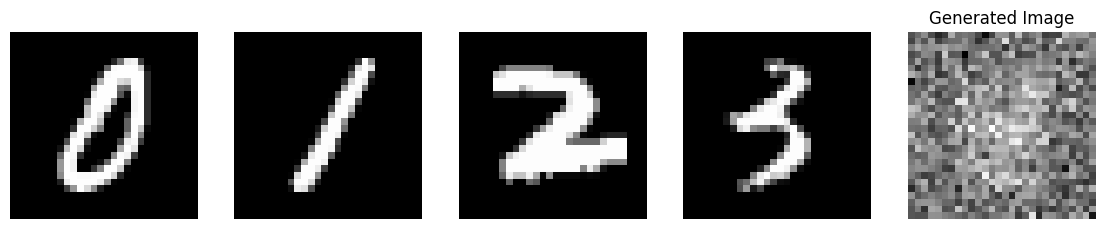

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


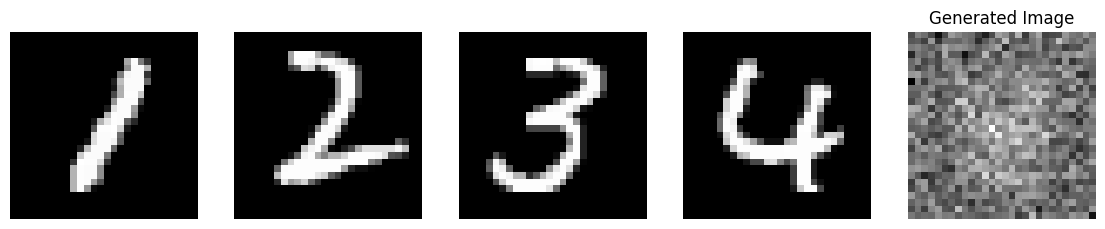

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


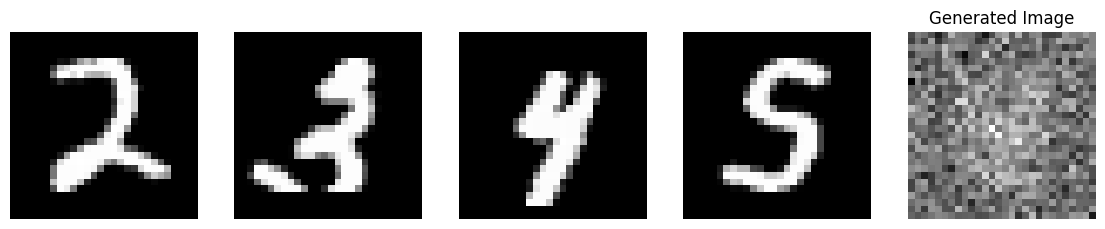

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


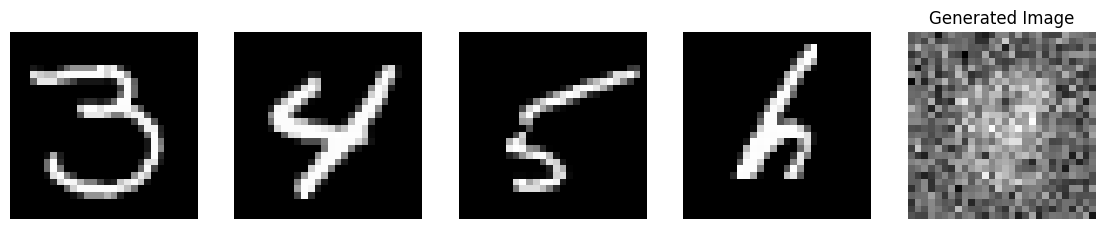

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


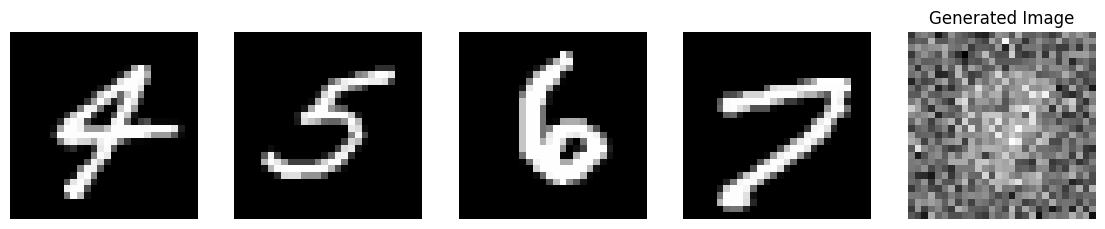

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


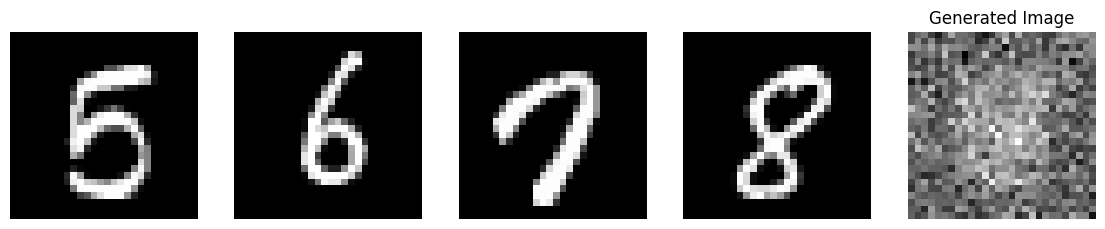

In [7]:
# optimizer = SGD(Stochastic Gradient Descent)

model.train('sgd', 2)

for i in [0, 3, 30, 117, 125, 12]:
    test_model_prediction(model, X_test, i)

Epoch 1/2
824/824 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0694 - mse: 0.0694
Epoch 2/2
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0600 - mse: 0.0600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


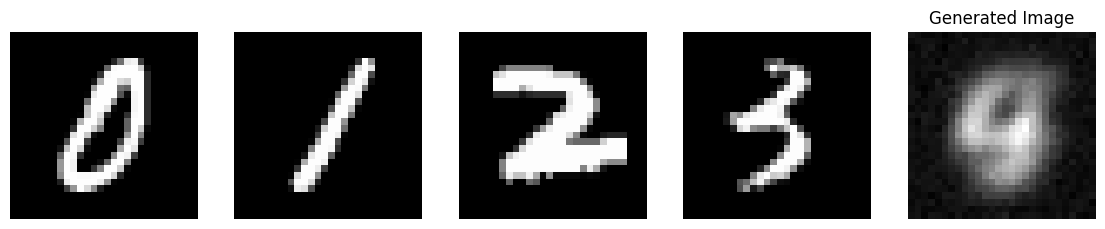

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


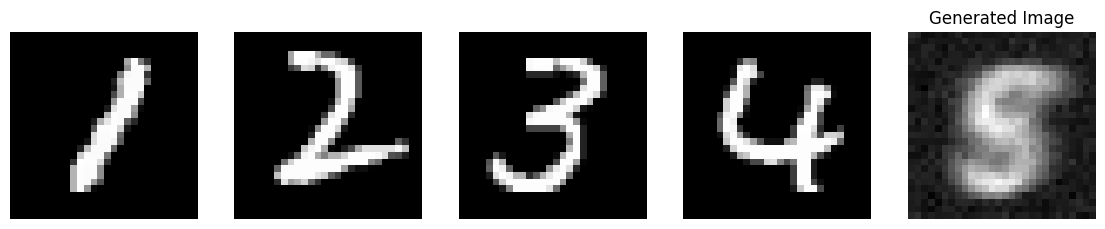

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


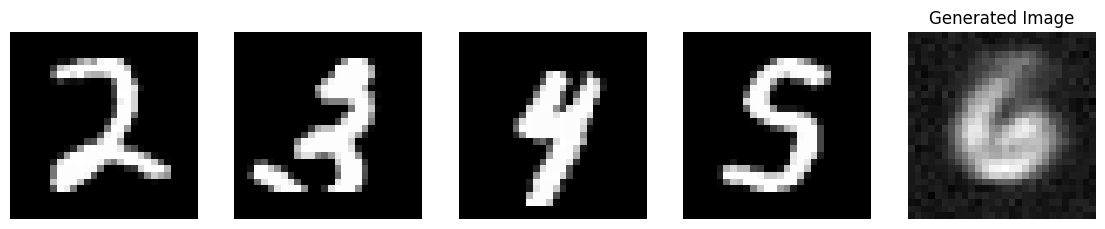

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


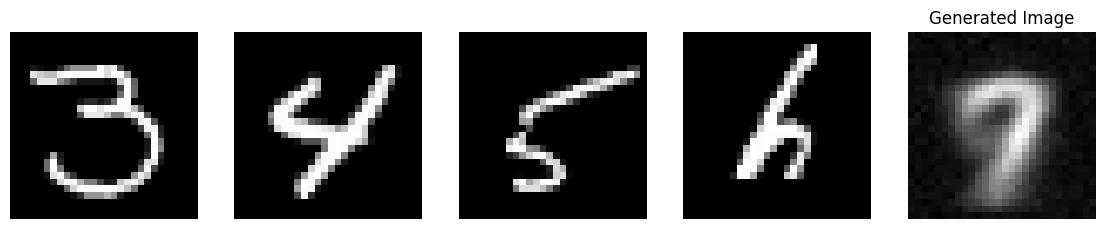

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


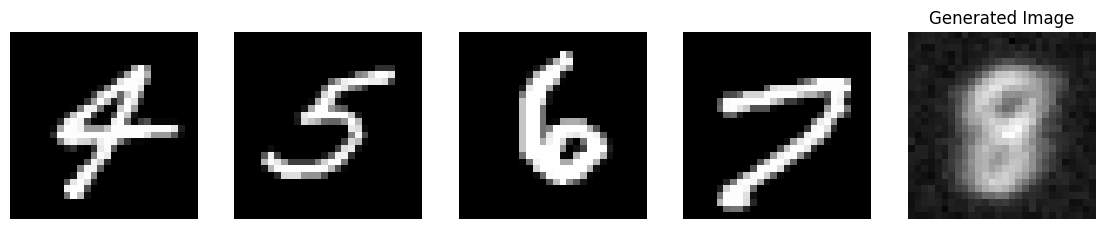

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


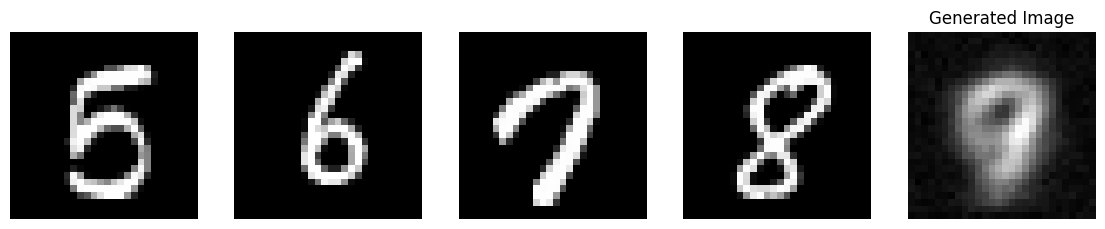

In [9]:
# optimizer = RMSPROP(Root Mean Squared Propagation)

model.train("rmsprop", 2)

for i in [0, 3, 30, 117, 125, 12]:
    test_model_prediction(model, X_test, i)

Epoch 1/2
824/824 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0556 - mse: 0.0556
Epoch 2/2
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0542 - mse: 0.0542
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


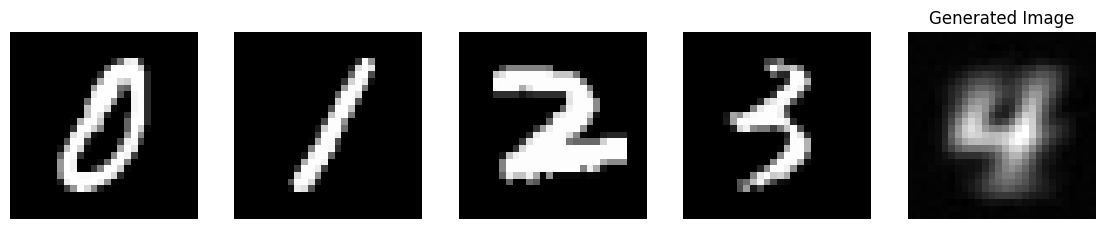

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


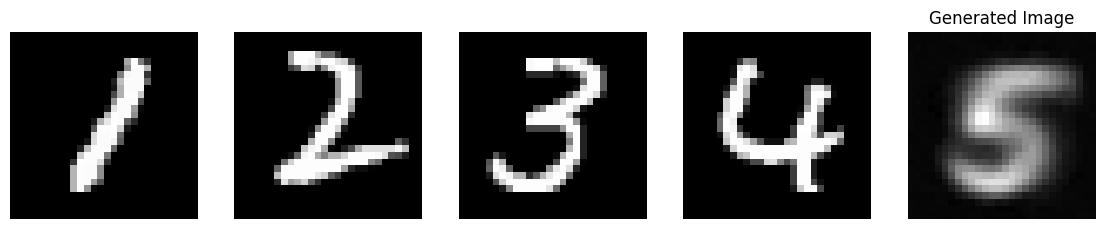

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


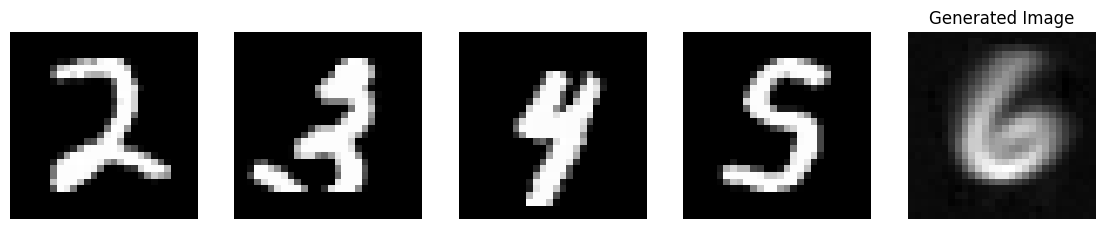

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


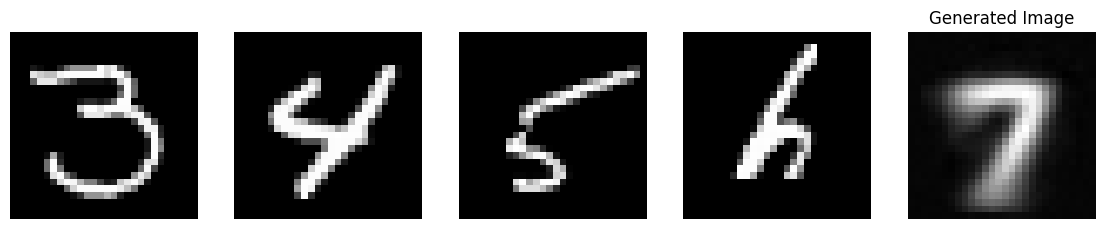

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


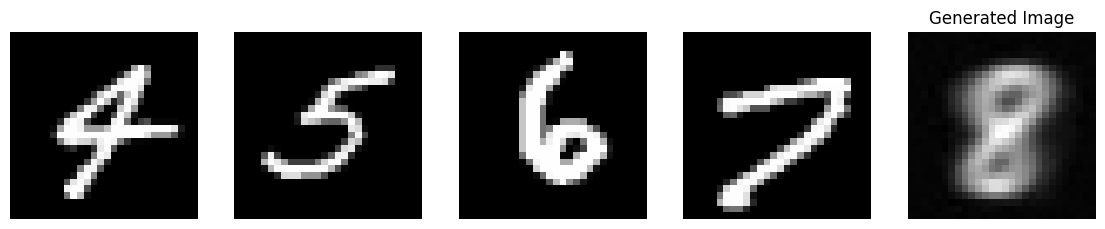

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


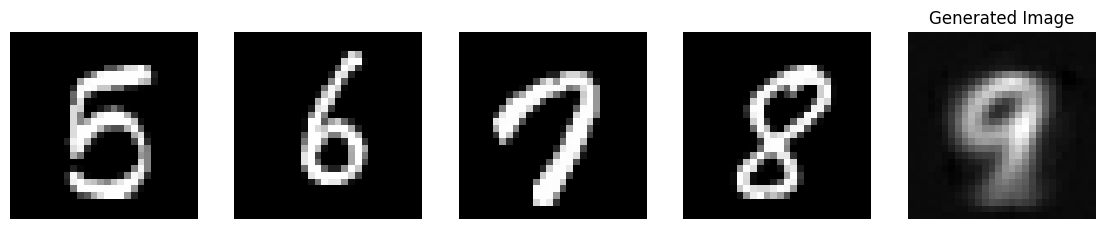

In [10]:
# optimizer = Adam

model.train("adam", 2)

for i in [0, 3, 30, 117, 125, 12]:
    test_model_prediction(model, X_test, i)